# Recognizing faces of friends

This notebook documents and shows how I have made a Convolutional Neural Network to recognize the faces of 3 friends

**`[Anish, Sir Chaitu, Rudra]`**

The GitHub repo for the complete project can be found below

[*Click here for GitHub*](https://github.com/monacotime/2.Recognizing-faces-of-friends)

## STEP 1: Importing the images from github to the virtual machine

Since i have got over 1500+ pictures of me and my frineds in the training set, it is not practical for me to upload them to the Google's VM everytime I want to use them on the Google's cloud service. 

It is not practical because my interent connection is slower (2 MBps) ( 25 mbps)

Whereas the connection of the Google VM to the GitHub server is ~36.85 MiB/s

Therefore I upload my images to the the GitHub repo only once and make Google download it from there using the `!git clone` command 

In [0]:
# Clone the repo.
!git clone -l -s https://github.com/monacotime/2.Recognizing-faces-of-friends.git

Cloning into '2.Recognizing-faces-of-friends'...
remote: Enumerating objects: 1633, done.
remote: Total 1633 (delta 0), reused 0 (delta 0), pack-reused 1633
Receiving objects: 100% (1633/1633), 1.30 GiB | 36.85 MiB/s, done.
Checking out files: 100% (1626/1626), done.


## STEP 2: Creating the Convolutional NN and training it

hence forth the actual processing and training of the model begins

### Importing the libraries

we have got to import the keras libray and some other libraries to work with our data:

- __ImageDataGenerator__

   because with this class, we can create augmented data using the pre existing data that we have. It has some properties to change the input image like:
   ```
    rescale = changes the value ( pixel data) eg: /255 -> between 0-1
    shear_range = stretch the imgae at an angle (shearing)
    zoom_range = zooms into the image 
    horizontal_flip = flips the image (true/false)
    ...
    ClassOfTypeImageDataGenerator.flow_from_directory()
      this function directly takes the image from the directory 
      and feeds it to the neural network
  ```
  more details on this function can be found in: 

  [Keras documentation for image Preprocessing](https://keras.io/api/preprocessing/image/#imagedatagenerator-class)

- __Sequential__

  The NN model we will be making is of type Sequential... 
  
  it has got one input node(tensor) and only one output node(tensor)

  why?

  because it has got Conv2D and MaxPooling2D in it? im not sure, can someone tell me why we use Sequential? 😕

  [Keras documentation for Sequential](https://keras.io/guides/sequential_model/)

- __Conv2D__

  from what i understand, Conv2D is a type of LAYER in keras that takes in a 2D image.
  
  The shape of the input is required to be specified when it is used in the first layer after which it may not be specified and it will find its shape from the previous layers

  [Keras documentation for Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/)

- __MaxPooling2D__

  Takes the maximum argument of the 2D image (pixel data) and simplifies the image (makes it smaller because the original number of pixels keep decreasing with each Argmax of pooling)

  Better explained later in the notebook

- __Activation, Dropout, Flatten, Dense__

  Applies an activation function to an output. You have to choose from the list of all the Activation functions

  [Activation](https://keras.io/api/layers/regularization_layers/dropout/)

  The Dropout layer randomly sets input units to 0 with a frequency of `rate` at each step during training time, which helps prevent overfitting. Inputs not set to `0` are scaled up by `1/(1 - rate)` such that the sum over all inputs is unchanged.
  [Dropout](https://keras.io/api/layers/regularization_layers/dropout/)

  > "*Just your regular densely-connected NN layer.*" - Keras documentation about Dense layers

  [Dense](https://keras.io/api/layers/core_layers/dense/)

- __image__

  ``` python
  from keras.preprocessing import image
  ```

  Not sure what this is 

- __np and os__

  We all know what this is right? I dont need to write anything right? RIGHT? **YES, IM TALKING TO YOU, FUTURE ME** 😡

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import numpy as np
from keras.preprocessing import image
import os


Using TensorFlow backend.


### Initializing control variables

pretty straight forward, `img_size` and other control global variables are declared

the data directory below is local to the VM and not my pc, it is taking the data from the VM directory and not mine

In [0]:
img_width, img_height = 64, 64

train_data_dir = '/content/2.Recognizing-faces-of-friends/project files/images/train images'
test_data_dir = '/content/2.Recognizing-faces-of-friends/project files/images/valid images'
nb_train_samples = 1578
nb_valid_samples = 30
image_channel = 1
batch_size = 20
epochs = 5

### Pre processing the data to be fed into the network

Usinf the `ImageDataGenerator` we are augmenting the data and making more data out of the original data by varying the parameter detailed above already

And by using the `flow_from_directory()` we are setting it up so that the images from the directory are being directly fed into the neural network input layer

we are doing this for both train and validation data 

while we are not changing too much of the validation data compared to train data because we want it to be as close to the original picture that was taken so we are just changing the scales as in we are making the 0-255 RGB values into 0-1 GreyScale data and feeding it to the NN


In [0]:
if K.image_data_format() == 'channels_first':
    input_shape = (image_channel, img_width, img_width)
else:
    input_shape = (img_width, img_height, image_channel)


train_datagen = ImageDataGenerator(
    rescale = 1. /255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

valid_datagen = ImageDataGenerator(
    rescale = 1. /255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    color_mode = "grayscale",
    batch_size = batch_size,
    class_mode = 'categorical')


valid_generator = valid_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_width, img_height),
    color_mode = "grayscale",
    batch_size = batch_size,
    class_mode = 'categorical')

Found 1578 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


### Structure and working of the convolutional Neural Network

*okay bois hold onto your pants now*

---

the way this works is...

![conv nn](https://miro.medium.com/max/2000/1*vkQ0hXDaQv57sALXAJquxA.jpeg)

Okay lets break it down step by step: 

1. First, if you have eyes, you will see that on the left a picture of a fantastic blue car is taken as an input

2. A Box, called Conv2D below, takes the pixels on the image and then projects it onto itself and applies an `activation` to it.

  now whats an `activation` you ask? so basically it decides if the pixel value is "bright enough" or "important enogh" for the network to even care. and this is done using a curve caled a rectified linear unit or in short ReLU. 
  
  Want to see what the curve looks like?

  ![relu](https://miro.medium.com/max/357/1*oePAhrm74RNnNEolprmTaQ.png)

  this here is relu, its a simple graph. okay now that is out the way lets go to the next thing called `Convloving`? `Convoluting`?
  
  well the thing is... see this 

  ![alt text](https://miro.medium.com/max/1000/1*GcI7G-JLAQiEoCON7xFbhg.gif)

  You have to understand what a `kernal` and `weights` is first

  and that Yellow thing that is moving and you can see it is called a `kernal`, it has got its `weights` in red if you can see it closely and that is what desides what values get passed onto the convolved features 
  
  in the picture above the `kernal` is: 

  ```
  K= 
  1  0  1
  0  1  0
  1  0  1
  ```
  and this kernal goes down the page in this manner:

  ![alt text](https://miro.medium.com/max/1400/1*ciDgQEjViWLnCbmX-EeSrA.gif)

  Here the "page" is the input space of the Convolutional layer.

  in this manner the Convolutional layer is able to extract the `features` from the image and then store it in a smaller matrix of the extracted `features`.

  the extracted matrix of feature is smaller because it is very feature dense as shown below: 

  ![alt text](https://miro.medium.com/max/790/1*1VJDP6qDY9-ExTuQVEOlVg.gif)

   And this way we extract the higher level features in the input and decrease the computional necessaty by making the input space to the next layer even smaller. 

   The now extracted feature matrix is then passed into a `MaxPooling2D` layer if you notice below in the codes.

3. Pooling, or in our case MaxPooling2D, takes the image from the output of the previous layer (Conv2D layer that applies the activation to the input) and then takes only the max values in a kernal...

  okay lets break it down

  Similar to the `Convolutional Layer`, the `Pooling layer` is responsible for reducing the spatial size of the `Convolved Feature`. This is to decrease the computational power required to process the data through dimensionality reduction. Furthermore, it is useful for extracting dominant features which are rotational and positional invariant, thus maintaining the process of effectively training of the model.

  how the pooling layer works looks very similar to how the convolutional layer works: 

  ![alt text](https://miro.medium.com/max/792/1*uoWYsCV5vBU8SHFPAPao-w.gif)

  regular pooling vs max pooling: 

  ![](https://miro.medium.com/max/1000/1*KQIEqhxzICU7thjaQBfPBQ.png)

  if you noticed above, the max pooling only takes the maximum value instead of the average. this has performs better aparantly due to reasons beyond me.

---

>Ayway, this process of `1 -> 2 -> 3` is repeated 3 times in our code to extract very high level features

And then the final output after doing it 3 times is taken to a `flatten` layer

this layer makes our 2D vector into a 1D array and then inputs it into a `Dense` layer. 

Details of the `Dense` layer has been already provied above.

This `Dense` layer then converges to give only one selected `Categories` of outputs.

You can see it in this diagram: 

![alt text](https://miro.medium.com/max/1400/1*kToStLowjokojIQ7pY2ynQ.jpeg)

Where you see:

```
class 1
class 2
class 3
class 4
class 5
```

we will only have:

```
class 1
class 2
class 3

where 
  class 1 = "Anish"
  class 2 = "Sir Chaitu"
  class 3 = "Rudra"
```

and force the Network to chose only 3 class.

AND HENCE WE WILL HAVE OUR IMAGE CLASSIFIER 🎉

In [0]:
model = Sequential()
model.add(Conv2D(32,(3,3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

#model.summary()

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

model.compile(loss = 'categorical_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)       

### Training the Network

Here we train the model by calling the simple method called 

`model.fit_generator()`

more detail about it can be found on: 

[More details about fit_generator()](https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/)

In [0]:
model.fit_generator(train_generator,
                   steps_per_epoch = nb_train_samples,
                   epochs = epochs,
                   validation_data = valid_generator,
                   validation_steps = nb_valid_samples)

Epoch 1/5
1578/1578 [==============================] - 1521s 964ms/step - loss: 0.1381 - accuracy: 0.9495 - val_loss: 1.3111e-04 - val_accuracy: 1.0000
Epoch 2/5
1578/1578 [==============================] - 1488s 943ms/step - loss: 0.0220 - accuracy: 0.9937 - val_loss: 5.5192e-06 - val_accuracy: 1.0000
Epoch 3/5
1578/1578 [==============================] - 1491s 945ms/step - loss: 0.0120 - accuracy: 0.9965 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
1578/1578 [==============================] - 1530s 969ms/step - loss: 0.0155 - accuracy: 0.9969 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
1578/1578 [==============================] - 1532s 971ms/step - loss: 0.0131 - accuracy: 0.9970 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


## STEP 3: Saving the model so that we dont have to re-train it all the time

---

It's a simple `model.save_weights()` method that saves the weights of the trained model. 

I specified it to save it in `.h5` format because idk i saw some other guy do it okay idk why its better. Someone please tell me why it's better.

In [0]:
model.save_weights('colab_first_try.h5')

## STEP 4: Predicting images it has never seen before

---

***SO NOW IS FINALLY THE FUN PART***

I am importing some images in a seperate folder i had saved called `test images` and then making the trained model predict them using the `model.predict` method and desplaying the result

*It's all pretty basic, you should be able to understand from the code.*

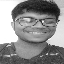

Anish


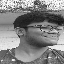

Anish


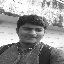

Sir Chaitu


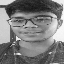

Anish


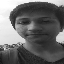

Rudra


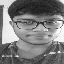

Anish


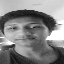

Rudra


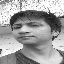

Rudra


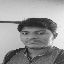

Sir Chaitu


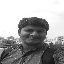

Sir Chaitu


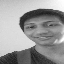

Rudra


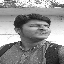

Sir Chaitu


In [0]:
test_path = '/content/2.Recognizing-faces-of-friends/project files/images/test images/'

for img_path in os.listdir(test_path):

    img_pred_pil=image.load_img( test_path + img_path, target_size=(64,64), color_mode='grayscale')

    display(img_pred_pil)

    img_pred_nparr = image.img_to_array(img_pred_pil)
    img_pred_nparr = np.expand_dims(img_pred_nparr,axis = 0)

    rslt = model.predict_classes(img_pred_nparr)

    if rslt == 0:
        print('Anish')
    elif rslt == 1:
        print('Sir Chaitu')
    else:
        print('Rudra')


## ***Conclusion***

---

If you look carefully, up above, with eyes. It seems like it has workd. It was able to correctly identify everyone without any error and it has achieved an 

>accuracy rate of 99.70% 

Which is jolly good. 

Honestly I am very exhausted after detailing everyting i have done and now i can use this model to predict between us 3 anytime i want. 

I have learnt a lot making this and it was super fun

time to move onto more complicated and challanging tasks


but not before i celebrate and reward myslef 🥳

![alt text](https://media.giphy.com/media/xeXEpUVvAxCV2/giphy.gif)